In [1]:
import os
import pandas as pd
import seaborn as sns
import folium

from matplotlib import pyplot as plt

In [8]:
file_path = '../../data/normalized_destinations_cat.parquet'

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")

df = pd.read_parquet(file_path)
df.dtypes

TripID                          int64
StartLatitude                 float64
StartLongitude                float64
StartTime         datetime64[ns, UTC]
EndLatitude                   float64
EndLongitude                  float64
EndTime           datetime64[ns, UTC]
StartPort                    category
EndPort                      category
time              datetime64[ns, UTC]
shiptype                        int64
Length                          int64
Breadth                         int64
Draught                       float64
Latitude                      float64
Longitude                     float64
SOG                           float64
COG                           float64
TH                              int64
Destination                  category
AisSourcen             string[python]
dtype: object

## ====================================
Here we can drop duplicates as we alredz normalized some stuff and it will detecte more of them than before

Then we will analzye what data is missing and how to deal with it

- do we fill it with median?
- do we drop it?
- do we consider it an anomaly?
- do we drop the whole trip?

## ====================================

In [9]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

df = df.drop_duplicates()
df = df.reset_index(drop=True)

Number of duplicate rows: 147086


<Axes: >

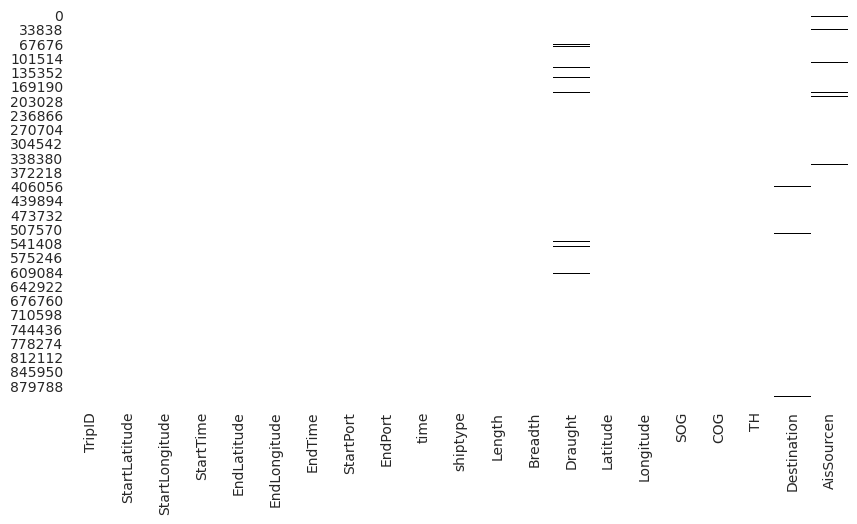

In [10]:
# Heat map to visualize missing data
cols = df.columns
plt.figure(figsize = (10,5))
sns.heatmap(df[cols].isnull(), cmap=['white', 'black'], cbar=False)

In [11]:
missing_percentage = df.isnull().sum() / len(df) * 100, 1
missing_percentage

(TripID            0.000000
 StartLatitude     0.000000
 StartLongitude    0.000000
 StartTime         0.000000
 EndLatitude       0.000000
 EndLongitude      0.000000
 EndTime           0.000000
 StartPort         0.000000
 EndPort           0.000000
 time              0.000000
 shiptype          0.000000
 Length            0.000000
 Breadth           0.000000
 Draught           1.778963
 Latitude          0.000000
 Longitude         0.000000
 SOG               0.000000
 COG               0.000000
 TH                0.000000
 Destination       0.573213
 AisSourcen        1.082286
 dtype: float64,
 1)

 Draught          1.778963
 Destination       0.573213
 AisSourcen        1.082286

Matches previous analysys +-

We can do median for Draught as I doubt it can indicate an anomaly, and it is a numerical value.

In [13]:
df.drop(columns=['AisSourcen'], inplace=True)  # Drop the 'AisSource' column as it is not needed really
df.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,time,shiptype,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,Destination
0,39131,53.57,8.53,2016-01-24 08:06:00+00:00,53.53,9.9,2016-01-24 16:44:00+00:00,BREMERHAVEN,HAMBURG,2016-01-24 08:07:00+00:00,71,277,42,11.54,53.57,8.53,0.7,331.2,143,DEHAM
1,39131,53.57,8.53,2016-01-24 08:06:00+00:00,53.53,9.9,2016-01-24 16:44:00+00:00,BREMERHAVEN,HAMBURG,2016-01-24 08:10:00+00:00,71,277,42,11.54,53.57,8.53,1.6,315.3,117,DEHAM
2,39131,53.57,8.53,2016-01-24 08:06:00+00:00,53.53,9.9,2016-01-24 16:44:00+00:00,BREMERHAVEN,HAMBURG,2016-01-24 08:10:00+00:00,71,277,42,11.54,53.57,8.53,2.8,322.6,100,DEHAM
3,39131,53.57,8.53,2016-01-24 08:06:00+00:00,53.53,9.9,2016-01-24 16:44:00+00:00,BREMERHAVEN,HAMBURG,2016-01-24 08:12:00+00:00,71,277,42,11.54,53.57,8.53,2.8,286.3,74,DEHAM
4,39131,53.57,8.53,2016-01-24 08:06:00+00:00,53.53,9.9,2016-01-24 16:44:00+00:00,BREMERHAVEN,HAMBURG,2016-01-24 08:16:00+00:00,71,277,42,11.54,53.57,8.53,4.3,333.1,333,DEHAM


In [16]:
df['Draught'] = df['Draught'].fillna(df['Draught'].median())

In [17]:
missing_percentage = df.isnull().sum() / len(df) * 100, 1
missing_percentage

(TripID            0.000000
 StartLatitude     0.000000
 StartLongitude    0.000000
 StartTime         0.000000
 EndLatitude       0.000000
 EndLongitude      0.000000
 EndTime           0.000000
 StartPort         0.000000
 EndPort           0.000000
 time              0.000000
 shiptype          0.000000
 Length            0.000000
 Breadth           0.000000
 Draught           0.000000
 Latitude          0.000000
 Longitude         0.000000
 SOG               0.000000
 COG               0.000000
 TH                0.000000
 Destination       0.573213
 dtype: float64,
 1)

### What to do with missing Destination values?

In [23]:
# Fill missing Destination values with the nearest value within the same TripID
df['Destination'] = df.groupby('TripID')['Destination'].transform(lambda x: x.ffill().bfill())
missing_percentage = df.isnull().sum() / len(df) * 100, 1
missing_percentage

(TripID            0.000000
 StartLatitude     0.000000
 StartLongitude    0.000000
 StartTime         0.000000
 EndLatitude       0.000000
 EndLongitude      0.000000
 EndTime           0.000000
 StartPort         0.000000
 EndPort           0.000000
 time              0.000000
 shiptype          0.000000
 Length            0.000000
 Breadth           0.000000
 Draught           0.000000
 Latitude          0.000000
 Longitude         0.000000
 SOG               0.000000
 COG               0.000000
 TH                0.000000
 Destination       0.007443
 dtype: float64,
 1)

In [24]:
# Get TripIDs where ALL 'Destination' values are missing
trips_with_no_destination = df.groupby('TripID')['Destination'].apply(
    lambda x: x.isna().all()
)
no_dest_trip_ids = trips_with_no_destination[trips_with_no_destination].index.tolist()

print(f"Number of trips with NO destination: {len(no_dest_trip_ids)}")
print("Example TripIDs:", no_dest_trip_ids[:5])  # Show first 5 for reference

Number of trips with NO destination: 2
Example TripIDs: [19002, 2200956]


In [25]:
# Filter the DataFrame to only include trips with no destination
no_dest_trips_df = df[df['TripID'].isin(no_dest_trip_ids)]

# Sort by TripID and time for clarity
no_dest_trips_df = no_dest_trips_df.sort_values(['TripID', 'time'])
no_dest_trips_df

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,time,shiptype,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,Destination
383861,19002,54.36,10.14,2016-03-27 20:05:00+00:00,54.45,18.68,2016-03-29 01:43:00+00:00,KIEL,GDYNIA,2016-03-28 19:45:00+00:00,0,0,0,6.14,54.89,17.80,12.5,85.2,87,NaN
383901,19002,54.36,10.14,2016-03-27 20:05:00+00:00,54.45,18.68,2016-03-29 01:43:00+00:00,KIEL,GDYNIA,2016-03-28 19:56:00+00:00,0,0,0,6.14,54.90,17.87,12.4,85.0,87,NaN
383883,19002,54.36,10.14,2016-03-27 20:05:00+00:00,54.45,18.68,2016-03-29 01:43:00+00:00,KIEL,GDYNIA,2016-03-28 19:59:00+00:00,0,0,0,6.14,54.90,17.89,12.4,84.8,87,NaN
383884,19002,54.36,10.14,2016-03-27 20:05:00+00:00,54.45,18.68,2016-03-29 01:43:00+00:00,KIEL,GDYNIA,2016-03-28 20:00:00+00:00,0,0,0,6.14,54.90,17.89,12.4,84.8,87,NaN
383885,19002,54.36,10.14,2016-03-27 20:05:00+00:00,54.45,18.68,2016-03-29 01:43:00+00:00,KIEL,GDYNIA,2016-03-28 20:01:00+00:00,0,0,0,6.14,54.90,17.90,12.4,84.8,87,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902877,2200956,54.36,10.14,2016-06-21 17:53:00+00:00,54.36,18.66,2016-06-23 11:13:00+00:00,KIEL,GDYNIA,2016-06-23 03:36:00+00:00,0,0,0,3.34,54.87,17.96,8.2,87.8,85,NaN
902878,2200956,54.36,10.14,2016-06-21 17:53:00+00:00,54.36,18.66,2016-06-23 11:13:00+00:00,KIEL,GDYNIA,2016-06-23 03:38:00+00:00,0,0,0,3.34,54.87,17.97,8.2,87.4,85,NaN
902879,2200956,54.36,10.14,2016-06-21 17:53:00+00:00,54.36,18.66,2016-06-23 11:13:00+00:00,KIEL,GDYNIA,2016-06-23 03:40:00+00:00,0,0,0,3.34,54.87,17.98,8.2,87.7,86,NaN
902880,2200956,54.36,10.14,2016-06-21 17:53:00+00:00,54.36,18.66,2016-06-23 11:13:00+00:00,KIEL,GDYNIA,2016-06-23 03:42:00+00:00,0,0,0,3.34,54.87,17.98,8.2,87.6,85,NaN


There is only two trips with no destination at all, is it an anomaly or not?

In [26]:
no_dest_trips = df[df['TripID'].isin(no_dest_trip_ids)]
normal_trips = df[~df['TripID'].isin(no_dest_trip_ids)]

print("Avg. duration (no destination):", no_dest_trips.groupby('TripID')['time'].apply(lambda x: x.max() - x.min()).mean())
print("Avg. duration (normal):", normal_trips.groupby('TripID')['time'].apply(lambda x: x.max() - x.min()).mean())

# Compare average SOG (Speed Over Ground)
print("Avg. SOG (no destination):", no_dest_trips['SOG'].mean())
print("Avg. SOG (normal):", normal_trips['SOG'].mean())

Avg. duration (no destination): 0 days 01:33:30
Avg. duration (normal): 0 days 17:52:51.672597864
Avg. SOG (no destination): 10.830882352941178
Avg. SOG (normal): 12.044668514395427


With  destination the average duration is significantly longer, and the average SOG is lower. This suggests that these trips might be anomalies or have different characteristics compared to normal trips. We will leaave them as is for now, but we can consider them as anomalies in the future.

In [27]:
# Save the cleaned DataFrame to a new Parquet file
output_file_path = '../../data/prepared_data.parquet'
df.to_parquet(output_file_path, index=False)